## Importing Python Packages

In [1]:
import os
import pathlib
import time
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm.autonotebook import tqdm;

plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

/tmp/ipykernel_51185/3061207847.py:15: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm;


In [2]:
tag = '2023-04-10-06-58-41-RadarNet-Short-V0'

## RadarPCL Model

In [3]:
class RadarPCL(nn.Module):
    
    def __init__(self,seq_len=4):
        super(RadarPCL, self).__init__()
        self.seq_len = seq_len
        self.conv_top = nn.Sequential(
            self._conv(4, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
        )
        self.conv_front = nn.Sequential(
            self._conv(4, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
            self._conv(64, 64, 7, 1, 0, 4, 1),
        )
        self.linear_top = nn.Sequential(
            nn.Linear(4*4*64, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Linear(64, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 16, bias=False),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Linear(16, 8, bias=False),
            nn.BatchNorm1d(8),
            nn.GELU(),
            nn.Linear(8, 4, bias=False),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 2, bias=False),
            nn.BatchNorm1d(2),
            nn.GELU(),
            nn.Linear(2, 1, bias=False),
            nn.BatchNorm1d(1),
            nn.GELU()
        )
        self.linear_front = nn.Sequential(
            nn.Linear(4*4*64, 512, bias=False),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Linear(64, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Linear(32, 16, bias=False),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Linear(16, 8, bias=False),
            nn.BatchNorm1d(8),
            nn.GELU(),
            nn.Linear(8, 4, bias=False),
            nn.BatchNorm1d(4),
            nn.GELU(),
            nn.Linear(4, 2, bias=False),
            nn.BatchNorm1d(2),
            nn.GELU(),
            nn.Linear(2, 1, bias=False),
            nn.BatchNorm1d(1),
            nn.GELU()
        )
        
    def _conv(self, in_channel, out_channel, kernel_size, stride, padding, dilation, groups):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.GELU()
        )
    
    def forward(self, I_top, I_front):
        batch_size = I_top.size(0)
        # Top-View
        x_top = self.conv_top(I_top)
        x_top = x_top.view(batch_size, -1)
        x_top = self.linear_top(x_top)
        # Front-View
        x_front = self.conv_front(I_front)
        x_front = x_front.view(batch_size, -1)
        x_front = self.linear_front(x_front)
        # Adding speed components
        x = x_top + x_front
        return x

In [4]:
seq_len = 1

In [5]:
model = RadarPCL(seq_len=seq_len)

In [6]:
summary(model, input_size=[(1, 4, 100, 100),(1, 4, 100, 100)])

/home/paulo/.pyenv/versions/venv.3.10.11/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/paulo/.pyenv/versions/venv.3.10.11/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RadarPCL                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 4, 4]             --
│    └─Sequential: 2-1                   [1, 64, 76, 76]           --
│    │    └─Conv2d: 3-1                  [1, 64, 76, 76]           12,544
│    │    └─BatchNorm2d: 3-2             [1, 64, 76, 76]           128
│    │    └─GELU: 3-3                    [1, 64, 76, 76]           --
│    └─Sequential: 2-2                   [1, 64, 52, 52]           --
│    │    └─Conv2d: 3-4                  [1, 64, 52, 52]           200,704
│    │    └─BatchNorm2d: 3-5             [1, 64, 52, 52]           128
│    │    └─GELU: 3-6                    [1, 64, 52, 52]           --
│    └─Sequential: 2-3                   [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-7                  [1, 64, 28, 28]           200,704
│    │    └─BatchNorm2d: 3-8             [1, 64, 28, 28]           12

## Dataset Class

In [7]:
class RadarDataset(Dataset):
    
    def __init__(self, path, seq_len=1, px=150, py=150, pz=150, rx=19.3*2, ry=19.3, rz=10., dAzi=15., dElev=15., dRoll=15., augment=True, transform=None):
        super(RadarDataset, self).__init__()
        
        self.path = path
        self.seq_len = seq_len
        self.px = px
        self.py = py
        self.pz = pz
        self.rx = rx
        self.ry = ry
        self.rz = rz
        self.dAzi = dAzi
        self.dElev = dElev
        self.dRoll = dRoll
        self.augment = augment
        self.transform = transform
        
        _, _, files = next(os.walk(path))
        print(f'>>> Found {len(files)} files in the selected directory. Building dataset...')
        pbar = tqdm(total=len(files))
        
        self.offset_dict = {}
        self.length = 0
        pathlib.Path(self.path + 'Processed').mkdir(parents=True, exist_ok=True)
    
        # Creating unified file to optimize RAM
        with open(self.path + 'Processed/unified-seq.txt', 'w') as u:
            for file in files:
                with open(self.path + file, 'r') as f:
                    # Data is a list(timestamp, list(detections), speed)
                    data = f.read().splitlines()
                    for i in range(seq_len-1, len(data)):
                        group = []
                        status = []
                        for j in range(i, i - seq_len, -1):
                            # Evaluating current line
                            curr = eval(data[j])
                            group.append([curr[0],curr[1],curr[2]])
                            status.append(curr[3])
                        # Saving data in a unified file if it contains at least one valid scan
                        if status[0] > 0:
                            self.offset_dict[self.length] = u.tell()
                            u.write(str(group)+'\n')
                            self.length += 1
                pbar.update(n=1)
            
        
    def __len__(self):
        return len(self.offset_dict)
    

    def __getitem__(self, id):
        # Reading data on demand
        offset = self.offset_dict[id]
        with open(self.path + 'Processed/unified-seq.txt', 'r', encoding='utf-8') as f:
            f.seek(offset)
            line = f.readline()
            # Processing recovered data
            group = eval(line)
            # Computing random angles to be used in the sequence
            dAzi = random.uniform(-self.dAzi,self.dAzi) * np.pi/180.
            dElev = random.uniform(-self.dElev,self.dElev) * np.pi/180.
            dRoll = random.uniform(-self.dRoll,self.dRoll) * np.pi/180.
            # Lists to store the sequence of data
            I_top_scans = []
            I_front_scans = []
            curr_speed = 0.
            for i, (t, data, speed) in enumerate(group):
                data = np.array(data)
                # Augmenting data
                if self.augment:
                    data = self._rotate(data, dAzi, dElev, dRoll)
                # We normalize the position vector to get speed components
                n = data[:,:3] / np.expand_dims(np.linalg.norm(data[:,:3], axis=1), axis=1)
                speed_xyz = n * np.expand_dims(data[:,5],axis=1)
                # Preparing tensors
                I_top = self._top(np.copy(data), speed_xyz, px=self.px, py=self.py, rx=self.rx, ry=self.ry)
                I_top = self.transform(I_top)
                I_front = self._front(np.copy(data), speed_xyz, px=self.px, pz=self.pz, rx=self.rx, rz=self.rz)
                I_front = self.transform(I_front)
                I_top_scans.append(I_top)
                I_front_scans.append(I_front)
                if i == 0:
                    curr_speed = speed
            I_top_scans = torch.cat(I_top_scans, dim=0)
            I_front_scans = torch.cat(I_front_scans, dim=0)
            speeds = torch.FloatTensor([curr_speed])
        return t, I_top_scans, I_front_scans, speeds
    
    
    def _rotate(self, data, dAzi, dElev, dRoll):
        ''' data has columns in the following order: x, y, z, rcs, snr, speed '''
        # Rotating points
        Rz = np.array([[np.cos(dAzi), -np.sin(dAzi), 0.],
                       [np.sin(dAzi), np.cos(dAzi), 0.],
                       [0., 0., 1.]])
        Ry = np.array([[np.cos(dElev), 0., np.sin(dElev)],
                       [0., 1., 0.],
                       [-np.sin(dElev), 0., np.cos(dElev)]])
        Rx = np.array([[1., 0., 0.],
                       [0., np.cos(dRoll), -np.sin(dRoll)],
                       [0., np.sin(dRoll), np.cos(dRoll)]])
        R = Rz @ Ry @ Rx
        pts = data[:,:3].T
        pts = R.dot(pts).T
        data[:,:3] = pts
        return data
        
    
    def _top(self, P, speed_xyz, px, py, rx, ry):
        ''' P has columns in the following order: x, y, z, rcs, snr, speed '''
        # Adjusting coordinates from radar to image
        P[:, [0,1]] = P[:, [1,0]]
        P[:, 0] *= -1
        I = np.zeros((py,px,4), dtype=np.float32)
        T = np.zeros((P.shape[0],2), dtype=np.uint16)
        # Computing mapped positions
        T[:,1] = np.uint16(np.maximum(np.minimum((px/rx) * P[:,0] + (px/2), px-1), 0))    
        T[:,0] = np.uint16(np.maximum(np.minimum((py/ry) * P[:,1], py-1), 0))
        # Mapping the space to the first layer
        I[T[:,0],T[:,1],0] = np.squeeze(P[:,2])
        # Mapping the rcs to the second layer
        I[T[:,0],T[:,1],1] = np.squeeze(P[:,3])
        # Mapping the snr to the second layer
        I[T[:,0],T[:,1],2] = np.squeeze(P[:,4])
        # Mapping the speed to the forth layer
        # In the top view, speed is composed by x and y
        I[T[:,0],T[:,1],3] = np.squeeze(speed_xyz[:,0]+speed_xyz[:,1])
        return I
    
    
    def _front(self, P, speed_xyz, px, pz, rx, rz):
        ''' P has columns in the following order: x, y, z, rcs, snr, speed '''
        # Adjusting coordinates from radar to image
        P[:, [0,1]] = P[:, [1,0]]
        P[:, 0] *= -1
        I = np.zeros((pz,px,4), dtype=np.float32)
        T = np.zeros((P.shape[0],2), dtype=np.uint16)
        # Computing mapped positions
        T[:,1] = np.uint16(np.maximum(np.minimum((px/rx) * P[:,0] + (px/2), px-1), 0))    
        T[:,0] = np.uint16(np.maximum(np.minimum((pz/rz) * P[:,2] + (pz/2), pz-1), 0))
        # Mapping the space to the first layer
        I[T[:,0],T[:,1],0] = np.squeeze(P[:,1])
        # Mapping the rcs to the second layer
        I[T[:,0],T[:,1],1] = np.squeeze(P[:,3])
        # Mapping the snr to the second layer
        I[T[:,0],T[:,1],2] = np.squeeze(P[:,4])
        # Mapping the speed to the forth layer
        # In the front view, speed is composed by z
        I[T[:,0],T[:,1],3] = np.squeeze(speed_xyz[:,2])
        return I

## Functions

In [8]:
def preview(model, dataloader, device, path, epoch, lr, show=False):
    model.eval()
    data = []
    est_t = []
    with torch.no_grad():
        for t, I_top, I_front, speed in dataloader:
            I_top = I_top.to(device=device)
            I_front = I_front.to(device=device)
            speed = speed.to(device=device)
            tic = time.time()
            y = model(I_top, I_front)
            toc = time.time()
            data.append([t.cpu().numpy()[0], speed.cpu().numpy()[0][0], y.cpu().numpy()[0][0]])
            est_t.append(toc-tic)
    data = np.array(data)
    fig, ax = plt.subplots(figsize=[12.8, 4.8])
    ax.plot(data[:,2], 'r', linewidth=0.5, label='$\hat{\mathbf{x}}$')
    ax.plot(data[:,1], 'b', linewidth=0.75, label='$\mathbf{x}$')
    ax.set_xlabel('Samples')
    ax.set_ylabel('m/s')
    ax.legend(loc='upper left', fancybox=False)
    ax.text(0, 1, f'LR = {lr}',
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes)
    ax.set_xlim([0,data.shape[0]])
    plt.savefig(path + 'epoch_' + str(epoch).rjust(4, '0') + '.png')
    if show:
        plt.show()
    plt.close(fig)
    print(f'Mean inference time: {np.mean(est_t)} s')
    print(f'RMSE: {mean_squared_error(data[:,1], data[:,2], squared=False)} m/s')
    df = pd.DataFrame(data, columns=['Time','ref_speed','speed'])
    return df

## Extracting data

In [9]:
t = transforms.Compose([transforms.ToTensor()])

In [10]:
px = 100
py = 100
pz = 100
rx = 20. * 2
ry = 20.
rz = 15.
dAzi = 15.
dElev = 15.
dRoll = 15.

In [11]:
model = RadarPCL(seq_len)

Loading weights

In [12]:
pretrained = torch.load('../checkpoints/' + tag + '/weights.pt', map_location=torch.device('cpu'))
pretrained.keys()

dict_keys(['epoch', 'test_loss', 'lr', 'model_state_dict', 'optimizer_state_dict'])

In [13]:
model.load_state_dict(pretrained['model_state_dict'])

<All keys matched successfully>

In [14]:
preview_data = RadarDataset('../synched/fr_V0/valid/', seq_len=seq_len, px=px, py=py, pz=pz, rx=rx, ry=ry, rz=rz, augment=False, transform=t)

>>> Found 1 files in the selected directory. Building dataset...


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


In [15]:
len(preview_data)

8860

In [16]:
preview_loader = DataLoader(preview_data, batch_size=1, drop_last=False, shuffle=False)

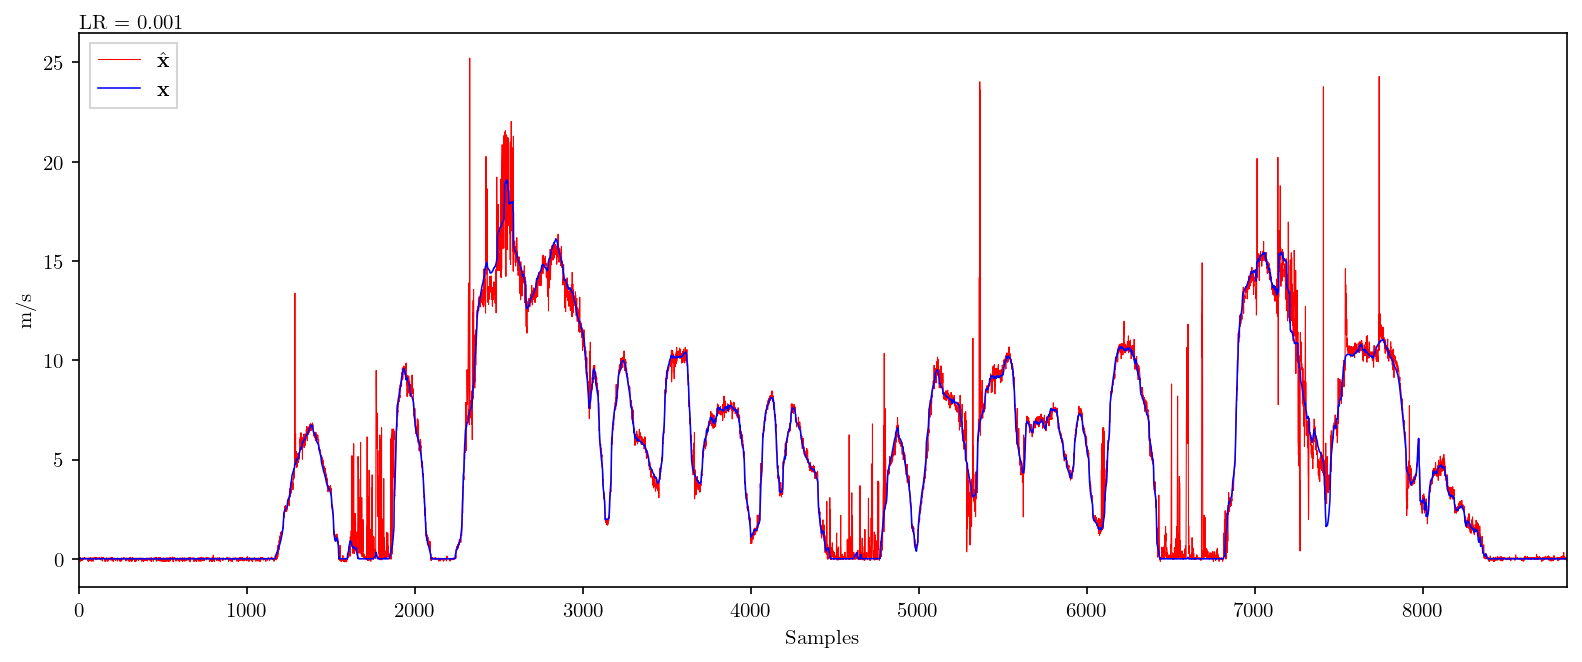

Mean inference time: 0.005561493723979114 s
RMSE: 0.9800584008925974 m/s


In [17]:
path = '../checkpoints/' + tag + '/'
lr = pretrained['lr']
epoch = pretrained['epoch']
df = preview(model, preview_loader, 'cpu', path, epoch, lr, show=True)

In [18]:
df.head()

,Time,ref_speed,speed
0,1.662410e+09,0.010007,-0.014026
1,1.662410e+09,0.010338,0.028859
2,1.662410e+09,0.008816,0.043684
3,1.662410e+09,0.010154,0.028260
4,1.662410e+09,0.009261,0.077996


In [19]:
df.to_csv('../processed/2022-09-05-16-29-36/front-right.csv', index=False)